<a href="https://colab.research.google.com/github/Charkaka/SC3000-AI/blob/main/SC3000_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 - Balancing a pole on a Cart

---

Members:
*   Charmain Ang Wan Theng (U2223590D)
*    Darrus Mok Khai Kiat (U2223371E)








Team Contributions:
  * Charmain : Setup, Task 1 and 3
  * Darrus : Setup, Task 1 and 2

## Description




>  A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left and right direction on the cart. In this project, you will need to develop a Reinforcement Learning (RL) agent. The trained agent makes the decision to push the cart to the left or right based on the cart position, velocity, and the pole angle, angular velocity.

## Q-learning


> Q-learning is a reinforcement method that seeks to find the best action to take given its current state. It is particularly well-suited for problems where the environment is initially unknown to the agent, and the agent must learn an optimal actions through trial and error interactions with the environment.

### Why Q-learning instead of other models?


> While more advanced algorithm like PPO has significant advantages for complex environment, high-dimensional state space, the CartPole challenge is a straightforward problem with limited number of states and just 2 potential actions, making it an ideal problem for Q-learning. This method is relatively easy to code from scartch and does not need high-end computing power.



# Set Up

## Install & Import Dependencies

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

## Render Video

In [ ]:
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## CartPole Environment Setup & Hyperparameter Initialisation

### Initialise CartPole environment

In [ ]:
environment = gym.make("CartPole-v1")

### Defining hyperparameters for learning process


**alpha**
> Learning Rate, it controls the rate at which the agent updates its knowledge.
> *   **Too high:** Agent will change its strategy too rapidly, can lead to erractic behavior where information learned from past is quickly overridden by newer.
*   **Too Low:** Slow learning, agent will be overly conservative and slow to adapt to new insights/changes in the environment

**gamma**
> Discount factor, determines importance of future rewards. Value that is close to '1' means future rewards are given nearly as much importnace as immediate rewards.

**epsilon**
> Exploration Rate, controls the trade-off between exploration and exploitation. Having a higher epsilon encourages more exploration, letting the agent try new actions.

**no_episodes**
> Number of training episodes, specifys number of episodes of training the agent will go through. Each episode is for the agent to learn from interacting with the environment from start to finish











In [ ]:
alpha = 0.15
gamma = 0.99
epsilon = 0.15
no_episodes = 10000

### Defining action and observation spaces


**actions & observations**

> defines the size of space in which actions and observations occur

**window_sizes**
> used to discretize the observations. Effectively scales down the continuous observation space into a more manageable size.



In [ ]:
actions = environment.action_space.n
observations = [30, 30, 50, 50]
window_sizes = np.array([0.25, 0.25, 0.01, 0.1])

#### Setting boundaries for observation (MIGHT REMOVE)

In [ ]:
max_values = [environment.observation_space.high[0], 0.5, environment.observation_space.high[2], np.radians(50)]
min_values = [environment.observation_space.low[0], -0.5, environment.observation_space.low[2], -np.radians(50)]

## Initialise Q-table with random values

In [ ]:
Q_table = np.random.uniform(low=0, high=1, size=(observations + [actions]))

## Discretization




### Function for Discretization Observation

> Allows the use of Q-learning by converting the continuous states into discrete states that the agent can learn from.

In [ ]:
def discretize_state(state):
    discrete_state = state/window_sizes + np.array([15, 10, 1, 10])
    return tuple(discrete_state.astype(int))

# Task 1 : Development of an RL agent



 **select_action function** returns a random action the agent should take in a given state. It uses the epsilon-greedy strategy, which involves choosing a random action with a probability of epsilon to explore the environment, and the best-known action according to the Q-table with a probability of (1 - epsilon) to exploit the accumulated knowledge.

In [ ]:
# Select an action for a given environmental state
def select_action(state):
    # Decision for action is based on epsilon-greedy approach
    if np.random.rand() < epsilon:  # Exploration decision
        # Act randomly for exploration
        return environment.action_space.sample()
    else:
        # Use the Q-table to exploit known information
        return np.argmax(Q_table[state])


**update_q_table** function updates the Q-table based on new experience. After taking an action and observing the outcome and reward, it calculates the Q-value for the state-action pair. It then finds the maximum predicted Q-value for the next state. Finally, it updates the Q-table entry for the state-action pair by blending the current Q-value with the reward received and the maximum future Q-value, scaled by the learning rate alpha and the discount factor gamma.

In [ ]:
# Amend the Q-table using new experience from the environment
def update_q_table(state, action_taken, reward_received, next_state):
    # Current Q-value for the state-action pair
    q_value_current = Q_table[state + (action_taken,)]

    # Maximum Q-value for the next state
    q_value_next = np.max(Q_table[next_state])

    # Update rule for Q-learning, blending new and old information
    Q_table[state][action_taken] = q_value_current + alpha * (
        reward_received + gamma * q_value_next - q_value_current)


**train_model** is the main function for training the model using Q-learning. It runs for a specified number of episodes. Each episode begins by resetting the environment and initialising variables. It then enters a loop where it selects actions, executes them, observes the outcomes, and updates the Q-table until the episode ends


In [ ]:
def train_model(no_episodes):

    for episode in range(no_episodes):
        # Begin with a fresh environment
        state = environment.reset()
        state = discretize_state(state)
        completed = False

        while not completed:
            # Action determination
            action = select_action(state)

            # Perform the chosen action
            new_state, reward, completed, _ = environment.step(action)
            new_state = discretize_state(new_state)

            # Update the Q-value table with the new experience
            update_q_table(state, action, reward, new_state)

            # Transition to the new state for the next iteration
            state = new_state

            # Output progress
            if episode % 100 == 0:
              print(f"Training progress: Episode {episode} of {no_episodes} complete.")

print('Training complete!')

Training complete!


In [ ]:
train_model(no_episodes)


Streaming output truncated to the last 5000 lines.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200 of 10000 complete.
Training progress: Episode 8200

In [ ]:
print(Q_table)


[[[[[5.06245507e-01 4.90218317e-01]
    [6.51857246e-01 2.82136115e-01]
    [2.42549484e-01 3.57778268e-01]
    ...
    [3.05762478e-01 8.13999441e-01]
    [9.21844654e-01 2.26672312e-01]
    [8.86325933e-01 5.58016525e-01]]

   [[7.25976814e-01 4.76539250e-01]
    [8.65115702e-01 8.76785411e-01]
    [9.99750749e-01 9.02632831e-01]
    ...
    [1.25198674e-01 4.68548155e-01]
    [7.60407322e-01 4.34750494e-01]
    [8.64331023e-01 4.03177409e-01]]

   [[1.71333891e-01 3.94326253e-01]
    [2.58963740e-01 5.45189601e-01]
    [4.87088904e-01 3.98412329e-01]
    ...
    [2.12334042e-01 5.45383152e-01]
    [7.43362407e-01 2.51070631e-01]
    [5.17100735e-01 1.13547361e-01]]

   ...

   [[8.06100918e-01 6.91808894e-01]
    [7.21704630e-02 8.22923094e-01]
    [4.49165340e-01 3.02373407e-01]
    ...
    [6.74188684e-01 4.14333942e-01]
    [6.73165003e-01 7.88585147e-01]
    [8.89259161e-01 8.45043064e-01]]

   [[2.84284806e-01 7.92304845e-01]
    [1.56954651e-01 5.74027539e-01]
    [9.18006310e

For task 1, the observation and chosen action is shown below:

In [ ]:
observation = environment.reset()
print("Observation: ", observation)
observation = discretize_state(observation)
action = select_action(observation)
print("Action: ", action)

Observation:  [ 0.01200787 -0.00822621 -0.03073558 -0.0008402 ]
Action:  0


# Task 2: Demonstrate effectiveness of RL agent



Unlike the select_action function, the choose_action function determines and returns the optimal action by utilizing the trained Q-table.

In [ ]:
## This function is used to choose action after obtaining a fine Q-table
def choose_action(observation):
    return np.argmax(Q_table[observation])


For Task 2, we will assess the performance of the agent we created in Task 1 by having it play the game across 100 episodes.

In [ ]:
result = []
for i in range(100):
    observation = environment.reset()
    observation = discretize_state(observation)
    cumulative_reward = 0
    done = False
    while not done:
        # Choose action base on current observation
        action = choose_action(observation)

        # Take action
        new_observation, reward, done, info = environment.step(action)
        new_observation = discretize_state(new_observation)

        observation = new_observation
        cumulative_reward += reward
    result.append(cumulative_reward)

The cumulative reward will then be displayed in a graph below

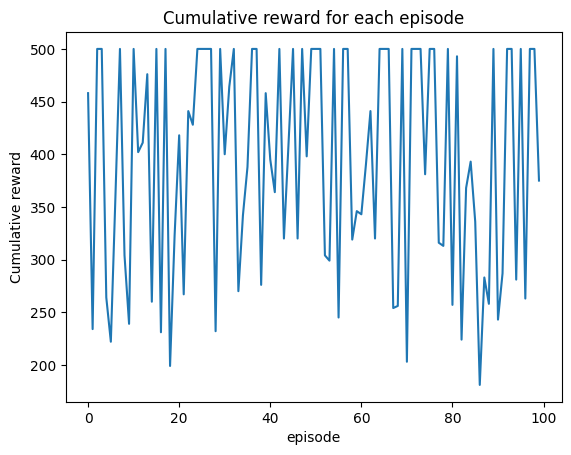

In [ ]:
result = np.array(result)
plt.plot(result)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()


Given that the average reward across 100 episodes exceeds 195, this indicates the agent's effectiveness in its performance.

In [ ]:
print("Average cumulative reward:", result.mean())
print("Is my agent good enough?", result.mean() > 195)

Average cumulative reward: 394.44
Is my agent good enough? True


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Running the simulation again might yield different outcomes due to the presence of epsilon, which is the probability of taking a random action and can introduce slight variations in results. In Task 3 we aim to mitigate this variance by increasing the number of episodes, which should lessen the impact of randomness. However, it's important to note that while this approach may reduce variance, it cannot completely eliminate the inherent randomness, but it's expected to make the results more consistent over a larger number of episodes.

# Task 3: Render one episode played by the RL agent

In [ ]:
def show_video():
  mp4list = glob.glob('./*.mp4')
  print(mp4list)
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [ ]:
env_2 = RecordVideo(gym.make("CartPole-v1"), "./")
observation = env_2.reset()

accumulated_reward  = 0 #Initialise total reward tracker
observation = discretize_state(observation)

while True:
  env_2.render() #Visualise current state of environment

  # Apply selected action base on current state
  action = select_action(observation)

  #Apply action to env --> returns new observation, a reward for action taken, whether episode ended ('done'), and extra info
  new_observation, reward, done, info = env_2.step(action)

  #convert new observation to discrete state
  new_observation = discretize_state(new_observation)
  observation = new_observation

  accumulated_reward  += reward

  if done:
    break;

print(f"Total Reward: {accumulated_reward}")

env_2.close()
show_video()

/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Total Reward: 196.0
['./rl-video-episode-0.mp4']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Additional Section : Improving the agent

In task 2, we trained the agent with 10000 episodes. We will increase the episodes to 20000 to see if there is a noticeable difference

In [ ]:
train_model(20000) ## train the agent with another 20000 episodes

Streaming output truncated to the last 5000 lines.
Training progress: Episode 18500 of 20000 complete.
Training progress: Episode 18500 of 20000 complete.
Training progress: Episode 18500 of 20000 complete.
Training progress: Episode 18500 of 20000 complete.
Training progress: Episode 18500 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training progress: Episode 18600 of 20000 complete.
Training prog

In [ ]:
result_2 = []
for i in range(100):
    observation = environment.reset()
    observation = discretize_state(observation)
    cumulative_reward = 0
    done = False
    while not done:
        # Choose action base on current observation
        action = choose_action(observation)

        # Take action
        new_observation, reward, done, info = environment.step(action)
        new_observation = discretize_state(new_observation)

        observation = new_observation
        cumulative_reward += reward
    result_2.append(cumulative_reward)
result_2 = np.array(result_2)

print("Old average cumulative reward: ", result.mean())
print("New average cumulative reward: ", result_2.mean())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Old average cumulative reward:  394.44
New average cumulative reward:  500.0


As we can see, after training with another 20000 episodes, the average cumulative reward increases. Hence, we can conclude that training the agent with more episodes makes the agent more accurate.